In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import pprint as pp

import requests
import json
from difflib import get_close_matches
from difflib import SequenceMatcher

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import pairwise_distances

from scipy.spatial.distance import cosine

plt.style.use('seaborn')

In [2]:
genres_item_matrix = pd.read_csv('data/genres_item_matrix.csv', index_col='id')
tag_item_matrix = pd.read_csv('data/tag_item_matrix.csv', index_col='id')
tag_rank_item_matrix = pd.read_csv('data/tag_rank_item_matrix.csv', index_col='id')
title_df = pd.read_csv('data/title_df.csv', index_col='id')
adjusted_score_df = pd.read_csv('data/adjusted_score_df.csv', index_col='id')

In [3]:
binary_df = pd.concat([genres_item_matrix, tag_item_matrix], axis=1)
binary_df.head()

,action,adventure,comedy,drama,ecchi,fantasy,horror,mahou_shoujo,mecha,music,...,witch,work,wrestling,writing,wuxia,yakuza,yandere,youkai,yuri,zombie
id,,,,,,,,,,,,,,,,,,,,,
10161,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
99726,0,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98526,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
966,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4876,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
def get_anime_id(_user_preferred_title):
    id_list = []
    anime_id = title_df[title_df['userPreferred'].isin([_user_preferred_title])].index
    id_list.append(anime_id)
    
    return id_list[0].values[0]


def get_top_n_recommendations(anime_id, dataframe, similarity_matrix, n=5):
    positional_idx = dataframe.index.get_loc(anime_id)
    
    top_n = np.argsort(similarity_matrix[positional_idx,:])[-n-1:-1]
    recom_titles = []
    for idx, row in title_df.iloc[top_n,:].iterrows():
        if type(row['english']) != float:
            recom_titles.append(row['english'])
        else:
            recom_titles.append(row['userPreferred'])
    
    return recom_titles


        
def get_title_from_id(_id):
    '''Searches the title dataframe based on an anime id and tries to return the english title. 
    If an english title is not available, the "user preferred" is give. '''
    title = None
    if pd.isna(title_df.loc[title_df.index == _id, 'english']).values[0]:
        title = title_df.loc[title_df.index == _id, 'userPreferred'].values[0]
    else:
        title = title_df.loc[title_df.index == _id, 'english'].values[0]
    
    return title


def get_user_preferred(initial_search):
    '''Search the AniList API for a show based on a query.
    
    Returns the user preferred title 
    '''
    query = '''
    query ($search: String) {
      Media (type: ANIME, search: $search) {
        id
        title {
          romaji
          english
          native
          userPreferred
        }
      }
    }
    '''
    variables = {'search': initial_search}

    url = 'https://graphql.anilist.co'
    response = requests.post(url, 
                             json={'query': query, 
                                   'variables': variables})
    user_preferred_title = response.json()['data']['Media']['title']['userPreferred']

    return user_preferred_title


def view_features(search_term, df):
    _id = title_df[title_df['userPreferred'] == search_term].index
    _df = df.loc[_id,:]

    return list(_df.loc[:, (_df != 0).any(axis=0)].columns)



def view_features_from_id(_id, _df):
    single_show = _df.loc[_id,:]
    
    return set(single_show[single_show != 0].index)



def get_common_tags(list_of_ids):
    list_of_tags = [view_features_from_id(_id, binary_df) for _id in list_of_ids]

    return set.intersection(*list_of_tags)

In [9]:
def get_recommendations(search_term, similarity_matrix=sim_mat):
    user_preferred_title = get_user_preferred(search_term)
    _id = get_anime_id(user_preferred_title)
    print('Getting recommendations for: ', get_title_from_id(_id))
    rec_list = get_top_n_recommendations(_id, 
                                         rank_df, 
                                         similarity_matrix, 
                                         n=5)
    return rec_list



In [6]:
rank_df = pd.concat([genres_item_matrix, tag_rank_item_matrix], axis=1)
rank_df.head()

,action,adventure,comedy,drama,ecchi,fantasy,horror,mahou_shoujo,mecha,music,...,witch,work,wrestling,writing,wuxia,yakuza,yandere,youkai,yuri,zombie
id,,,,,,,,,,,,,,,,,,,,,
10161,1,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.44,0.0,0.0,0.0
99726,0,1,1,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
98526,1,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
966,0,0,1,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
4876,1,1,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0


In [7]:
sim_mat = cosine_similarity(rank_df.values)

In [10]:
get_recommendations("Akira")

Getting recommendations for:  Akira


['Blame! Movie',
 'X Densha de Ikou',
 'Genocyber',
 'Texhnolyze',
 'Towanoquon: The Complicity of Dreams']

In [11]:
get_recommendations('Fullmetal')

Getting recommendations for:  Fullmetal Alchemist: Brotherhood


['Fullmetal Alchemist: The Sacred Star of Milos',
 'Plunderer',
 'Fullmetal Alchemist: Reflections',
 'The Heroic Legend of Arslan',
 'Fullmetal Alchemist']

## Penalizing Lowly Rated Content

In [12]:
adjusted_score_df.head()

,pop_scaled,score_scaled,adjusted_score
id,,,
10161,0.158971,0.71,0.650287
99726,0.239225,0.75,0.692942
98526,0.010887,0.58,0.522631
966,0.026901,0.73,0.658964
4876,0.005242,0.61,0.549320


In [13]:
a = .1
adjusted_scores = ((adjusted_score_df['adjusted_score'] * a) + .9)
adjusted_scores

id
10161     0.965029
99726     0.969294
98526     0.952263
966       0.965896
4876      0.954932
            ...   
99586     0.959066
99916     0.968809
101283    0.961290
101633    0.966854
101089    0.900000
Name: adjusted_score, Length: 9832, dtype: float64

In [14]:
sim_mat

array([[1.        , 0.        , 0.50399334, ..., 0.        , 0.15144281,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.05894477, 0.23248034,
        0.35867658],
       [0.50399334, 0.        , 1.        , ..., 0.        , 0.21774329,
        0.        ],
       ...,
       [0.        , 0.05894477, 0.        , ..., 1.        , 0.        ,
        0.04412823],
       [0.15144281, 0.23248034, 0.21774329, ..., 0.        , 1.        ,
        0.34808671],
       [0.        , 0.35867658, 0.        , ..., 0.04412823, 0.34808671,
        1.        ]])

In [15]:
weighted_sim_mat = (sim_mat * adjusted_scores.to_numpy())
weighted_sim_mat

array([[0.96502869, 0.        , 0.47993428, ..., 0.        , 0.14642307,
        0.        ],
       [0.        , 0.96929419, 0.        , ..., 0.05666303, 0.22477452,
        0.32280893],
       [0.48636803, 0.        , 0.95226315, ..., 0.        , 0.21052595,
        0.        ],
       ...,
       [0.        , 0.05713483, 0.        , ..., 0.96129011, 0.        ,
        0.03971541],
       [0.14614666, 0.22534184, 0.20734891, ..., 0.        , 0.96685389,
        0.31327804],
       [0.        , 0.34766313, 0.        , ..., 0.04242003, 0.33654899,
        0.9       ]])

In [16]:
get_recommendations('Fullmetal')

Getting recommendations for:  Fullmetal Alchemist: Brotherhood


['Fullmetal Alchemist: The Sacred Star of Milos',
 'Plunderer',
 'Fullmetal Alchemist: Reflections',
 'The Heroic Legend of Arslan',
 'Fullmetal Alchemist']

In [17]:
get_recommendations('Fullmetal', weighted_sim_mat)

Getting recommendations for:  Fullmetal Alchemist: Brotherhood


['Fullmetal Alchemist: The Sacred Star of Milos',
 'Fullmetal Alchemist: Reflections',
 'Magi: The Kingdom of Magic',
 'The Heroic Legend of Arslan',
 'Fullmetal Alchemist']

In [18]:
get_recommendations("Wolf's Rain")

Getting recommendations for:  Wolf's Rain


['Wan Wan Chuushingura',
 "Wolf's Rain OVA",
 'Galilei Donna',
 'Jyu-Oh-Sei: Planet of the Beast King',
 'Final Fantasy VII: Last Order']

In [19]:
get_recommendations("Wolf's Rain", weighted_sim_mat)

Getting recommendations for:  Wolf's Rain


['Kingsglaive Final Fantasy XV',
 "Wolf's Rain OVA",
 'Galilei Donna',
 'Jyu-Oh-Sei: Planet of the Beast King',
 'Final Fantasy VII: Last Order']

<b> There we go! "Wan Wan Chuushingura" is out while maintaining the rest of the top 5. </b>

## Recommendations for Sample User Profiles

In [199]:
# list of titles to list of ids
title_list = ['Space Dandy', 'Ergo Proxy']
id_list = []
for title in title_list:
    user_preferred_title = get_user_preferred(title)
    _id = get_anime_id(user_preferred_title)
    id_list.append(_id)
    print(user_preferred_title, _id)

Space☆Dandy 20057
Ergo Proxy 790


In [200]:
rank_df.loc[id_list,:]

,action,adventure,comedy,drama,ecchi,fantasy,horror,mahou_shoujo,mecha,music,...,witch,work,wrestling,writing,wuxia,yakuza,yandere,youkai,yuri,zombie
id,,,,,,,,,,,,,,,,,,,,,
20057,0,0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
790,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [201]:
list_of_sim_vecs = []
for _id in id_list:
    list_of_sim_vecs.append(weighted_sim_mat[rank_df.index.get_loc(_id)])

In [202]:
list_of_sim_vecs = np.asarray(list_of_sim_vecs)
list_of_sim_vecs

array([[0.16279517, 0.17821851, 0.08314897, ..., 0.1135313 , 0.14093281,
        0.        ],
       [0.28520247, 0.12353412, 0.0879336 , ..., 0.36050394, 0.        ,
        0.04104512]])

In [203]:
list_of_sim_vecs.shape

(2, 9832)

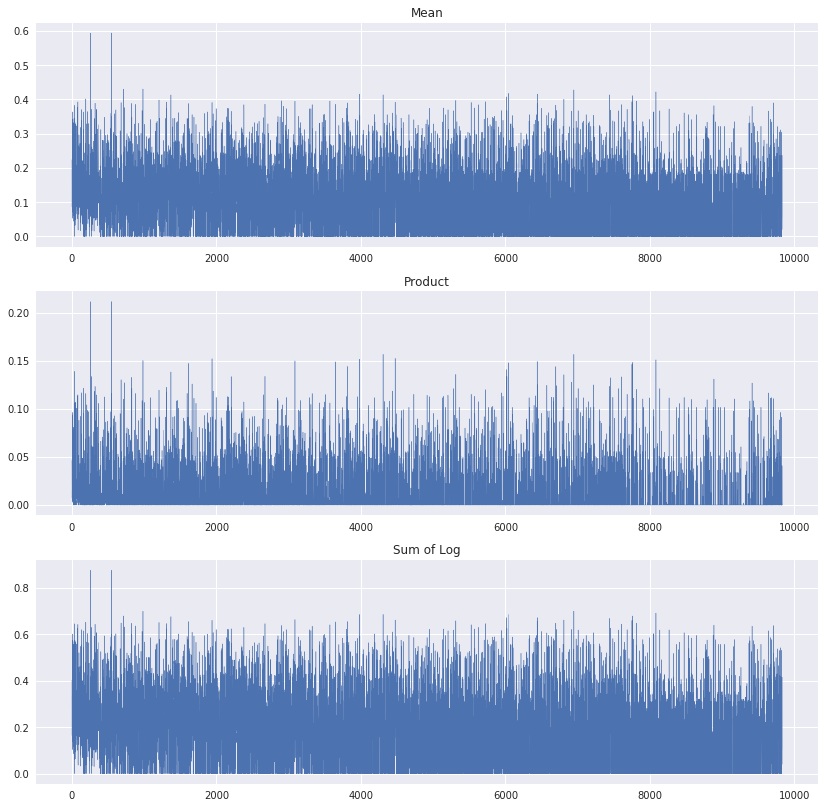

In [204]:
fig, ax = plt.subplots(3, 1, figsize=(14,14))
ax[0].plot(np.mean(list_of_sim_vecs, axis=0), linewidth=.4)
ax[0].set_title('Mean')
ax[1].plot(np.prod(list_of_sim_vecs, axis=0), linewidth=.4)
ax[1].set_title('Product')
ax[2].plot(np.sum(np.log(list_of_sim_vecs+1), axis=0), linewidth=.4)
ax[2].set_title('Sum of Log');

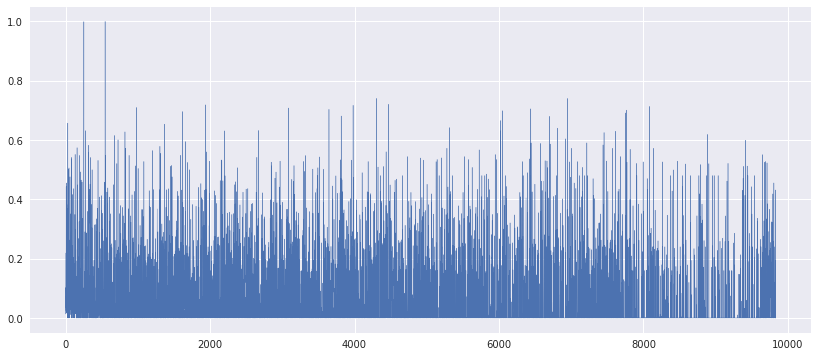

In [205]:
prod_vec = np.prod(list_of_sim_vecs, axis=0)
prod_vec /= np.max(prod_vec)
fig, ax = plt.subplots(figsize=(14,6))
ax.plot(prod_vec, linewidth=.4);

In [206]:
prod_vec.shape

(9832,)

In [207]:
prod_vec.argsort()[-10:]

array([3087,  983, 8084, 3980, 1939, 4474, 6948, 4307,  253,  547])

In [213]:
mean_vec = np.mean(list_of_sim_vecs, axis=0)

In [208]:
# get the mean vector for a list of anime
mean_vector = rank_df.loc[id_list,:].mean(axis=0)
mean_vector

action       0.0
adventure    0.0
comedy       0.5
drama        0.0
ecchi        0.0
            ... 
yakuza       0.0
yandere      0.0
youkai       0.0
yuri         0.0
zombie       0.0
Length: 265, dtype: float64

In [209]:
# measure the cosine similarity between our mean vector and every item in our dataset
dist_list = []
for anime in rank_df.iterrows():
    dist_list.append(cosine(mean_vector, anime[1]))
dist_series = pd.Series(dist_list, index=rank_df.index)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [210]:
title_list

['Space Dandy', 'Ergo Proxy']

In [211]:
# USING A NORMALIZED PRODUCT VECTOR OF SIMILARITY VECTORS
for _loc in prod_vec.argsort()[-10:]:
    print(get_title_from_id(title_df.iloc[_loc].name))
    

The Girl Who Leapt Through Space
Doraemon
SOS TV Walpurgis Night Fever Episode 0
Fireball
Queen Millennia
Tamala 2010: A Punk Cat in Space
Star Cat Fullhouse
Saber Marionette R
Space Dandy
Ergo Proxy


In [214]:
# USING A NORMALIZED MEAN VECTOR OF SIMILARITY VECTORS
for _loc in mean_vec.argsort()[-10:]:
    print(get_title_from_id(title_df.iloc[_loc].name))

Saber Marionette R
Space☆Dandy Picture Drama
Fireball
PriPri Chi-chan!!
SOS TV Walpurgis Night Fever Episode 0
Star Cat Fullhouse
Sgt. Frog
Doraemon
Space Dandy
Ergo Proxy


In [212]:
# USING AVERAGE FEATURE VECTOR TO FIND MOST SIMILAR ELEMENTS IN A SIMILARITY MATRIX
# get the titles for our ids
for _id in list(dist_series.sort_values()[:10].index):
    print(get_title_from_id(_id))

Ergo Proxy
Space Dandy
Ghost in the Shell
Star Cat Fullhouse
Casshern Sins
Harmony
Ghost in the Shell: Stand Alone Complex 2nd GIG
SOS TV Walpurgis Night Fever Episode 0
Ghost in the Shell 2: Innocence
Chikkun Takkun


It appears that first finding our feature vectors for our starter shows, then calculating the mean vector, and using that mean vector to find the most similar items is working the best. 